# DiploDatos 2022 - Mentoría "Churn Prediction: ¿Cómo retengo a mis clientes? Machine Learning aplicado a un caso de negocio"

Grupo 1:
- Marquez, Micael 
- Mantovani, María Laura
- Ruales, Fanny
- Ruiz, Rodrigo Hernán

#Importación de librerías

In [ ]:
# Analisis y visualizacion
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Clustering
from sklearn.cluster import KMeans,AgglomerativeClustering
!pip install --upgrade kneed
from kneed import KneeLocator

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#Lectura de archivo de datos desde Google Drive

In [ ]:
# Al ejecutar el código, se mostrará una ventana solicitando permisos de acceso a Drive con la cuenta de correo (personal)
# se deben aceptar los permisos para poder acceder al archivo compartido que contiene el dataset a trabajar

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

def connect_to_drive():
    auth.authenticate_user()
    gauth = GoogleAuth()
    gauth.credentials = GoogleCredentials.get_application_default()
    return GoogleDrive(gauth)

def read_csv_from_drive(drive, id, filename):
    downloaded = drive.CreateFile({'id':id}) 
    downloaded.GetContentFile(filename)  
    return pd.read_csv(filename)

drive = connect_to_drive()
salida_tp2 = read_csv_from_drive(drive, 'AirPassengers.csv')

In [ ]:
#Copia del DF original
df = salida_tp2.copy()
df.head(3)

,userId,sessionId,hour,day_week,day,month,last_level,time_reg_to_last,n_artists,n_songs,...,average_days_bt_session,distinct_count_of_days,if_error,error_count,if_help,help_count,churn_cancellation,pca1,pca2,pca3
0,0.0,0.0,0.173913,0.0,0.233333,0.0,1.0,0.195229,0.177632,0.122176,...,0.096735,0.163636,0.0,0.0,0.0,0.0,0.0,-0.722317,0.115193,-0.259434
1,0.0,0.0,0.173913,0.0,0.233333,0.0,1.0,0.195229,0.177632,0.122176,...,0.096735,0.163636,0.0,0.0,0.0,0.0,0.0,-0.722317,0.115193,-0.259434
2,0.0,0.0,0.173913,0.0,0.233333,0.0,1.0,0.195229,0.177632,0.122176,...,0.096735,0.163636,0.0,0.0,0.0,0.0,0.0,-0.722317,0.115193,-0.259434


<font color='mediumblue'>
Se decide quitar la granularidad por evento y sesión debido a que parece más útil identificar tipologías de usuarios de la aplicación.

In [ ]:
df = df.drop_duplicates(subset =['userId'], keep = 'first')

<font color='mediumblue'>
Se seleccionan aquellas variables que tiene sentido analizar por usuario únicamente.

In [ ]:
relevant= [#'hour', 'day_week', 'day', 'month',                                   #granularidad por evento
           'last_level',
           'time_reg_to_last', 'n_artists', 'n_songs', 'total_length',
           'total_length_session', 'n_sessions', 'avg_length_session', 'n_error',
           'avg_error_session', 'n_help', 'avg_help_session', 'n_interactions',
           'prop_error', 'prop_help', 
           'sessions_total_min', 
           'avg_session_duration',
           'n_RollAdvert', 'n_ThumbsDown', 'n_AddFriend', 'n_ThumbsUp',
           'n_SubmitDowngrade', 'days_from_last_interaction',
           'average_days_bt_session', 'distinct_count_of_days', 
           #'if_error', 'error_count', 'if_help', 'help_count',                   #se quitan por redundancia con otras columnas
           'churn_cancellation'
           #, 'pca1','pca2', 'pca3'                                               #granularidad por evento
          ]

Se analizarán los datos de los usuarios de la plataforma de streaming de música para identificar grupos de clientes “similares”, aplicando modelos de clústering. 

Tal vez la empresa pueda aplicar distintas estrategias de marketing para estos diferentes grupos identificados.

#1. Preparación de los datos para aplicar modelos de clustering

Evaluación visual e intuitiva de a dos variables por vez: Realizar visualizaciones de cómo se comportan las variables presentes en el dataset mediante el gráfico “pairplot”.

In [ ]:
n_cols = 5
n_rows = int((len(relevant)) // n_cols) + (len(relevant) % n_cols > 0)
x = 0
for i, col in enumerate(relevant):
    subplot = 0
    fig = plt.figure(figsize=(30, 40))
    for x in range(i,len(relevant)):
        subplot = subplot + 1
        ax = fig.add_subplot(n_rows, n_cols, subplot)
        ax.set_title(col + ' vs. ' + relevant[x])
        if x == i:
            sns.kdeplot(data=df, x=relevant[i], fill=True)#, hue='')
        else:
            sns.scatterplot(data=df, x=relevant[i], y=relevant[x], hue='churn_cancellation')
    print('*  '*50)
    print(col)
    fig.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
    plt.show()   
    plt.close()

Output hidden; open in https://colab.research.google.com to view.

##a. ¿Es posible en alguna de ellas visualizar “grupos” separados? ¿Qué variables presentan dicha separación? 

<font color='mediumblue'>
Tal como se observó en prácticos anteriores, no se visualizan grupos evidentes. Sin embargo, algunas variables cruzadas parecen agrupar los puntos de datos en función de la variable target. Es el caso de days_from_last_interaction contra todas las otras variables. También se observa alguna agrupación para el caso de average_days_bt_session vs n_songs, en donde bajas cantidades de ambas se asocian con usuarios que hicieron churn.

##b. ¿Se puede visualizar algún impacto de la variable target (Churn) en los posibles grupos?

<font color='mediumblue'>
Tal como se mencionó en el punto anterior, la variable target parece estar poco explicada por las variables que se incluyen en el análisis. 

##c. Si evalúa que es necesario, seleccione sólo algunas variables con las cuales se realizarán modelos de clústering.

<font color='mediumblue'>
Luego de un extensivo análisis gráfico de las variables de a pares en búsqueda de grupos de puntos, y para facilitar la aplicación de metodologías de clustering, se opta por llevar a cabo un embedding (PCA):

In [ ]:
from sklearn.decomposition import PCA
pre_pca= df[relevant].copy(deep=True)
n = min(30, pre_pca.shape[1]) 
pca = PCA(n_components=n)
principalComponents = pca.fit_transform(pre_pca)
print(principalComponents.shape)

(424, 26)


In [ ]:
print("Explained variance ratio")
print(pca.explained_variance_ratio_.round(2))

Explained variance ratio
[0.39 0.22 0.17 0.05 0.03 0.03 0.03 0.02 0.01 0.01 0.01 0.01 0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]


<font color='mediumblue'>
Para reducir el numero de variables en N componentes principales, se decide tomar 3 componentes ya que estos explican el 78% de la varianza de los datos.

In [ ]:
pca_df=pd.DataFrame(data= pca.components_, columns = pre_pca.columns, index   = ['PC1', 'PC2', 'PC3', 'PC4','PC5','PC6','PC7','PC8','PC9','PC10','PC11','PC12','PC13','PC14','PC15','PC16','PC17','PC18','PC19','PC20','PC21','PC22','PC23','PC24','PC25','PC26'])
pca_df[relevant].head(3)

,last_level,time_reg_to_last,n_artists,n_songs,total_length,total_length_session,n_sessions,avg_length_session,n_error,avg_error_session,...,avg_session_duration,n_RollAdvert,n_ThumbsDown,n_AddFriend,n_ThumbsUp,n_SubmitDowngrade,days_from_last_interaction,average_days_bt_session,distinct_count_of_days,churn_cancellation
PC1,0.597735,0.010933,0.263044,0.225817,0.201806,0.018206,0.174988,0.196571,0.150981,0.072393,...,0.196827,0.023194,0.214122,0.191012,0.186927,0.055481,-0.157666,-0.086982,0.268168,-0.031229
PC2,0.407036,-0.053638,-0.075549,-0.070928,-0.066511,0.013843,-0.086469,0.047615,-0.057341,-0.015073,...,0.046345,-0.023345,-0.049196,-0.066751,-0.066041,-0.064618,0.395061,-0.033847,-0.122566,0.773828
PC3,-0.614369,-0.005578,0.168887,0.161460,0.153682,-0.007880,0.184816,-0.044796,0.129432,-0.002743,...,-0.047200,0.139415,0.190139,0.149525,0.134049,0.197785,0.111634,-0.084516,0.220363,0.471168


In [ ]:
pre_pca.reset_index(inplace=True)

<font color='mediumblue'>
Se graficarán las primeras tres componentes de a pares, diferenciando con colores la variable target. Si bien a posteriori, los clusters obtenidos e identificados puedan no corresponderse necesariamente con los usuarios que hicieron Churn y los que no lo hicieron, puede que sea útil para identificar perfiles.

<Figure size 1080x360 with 0 Axes>

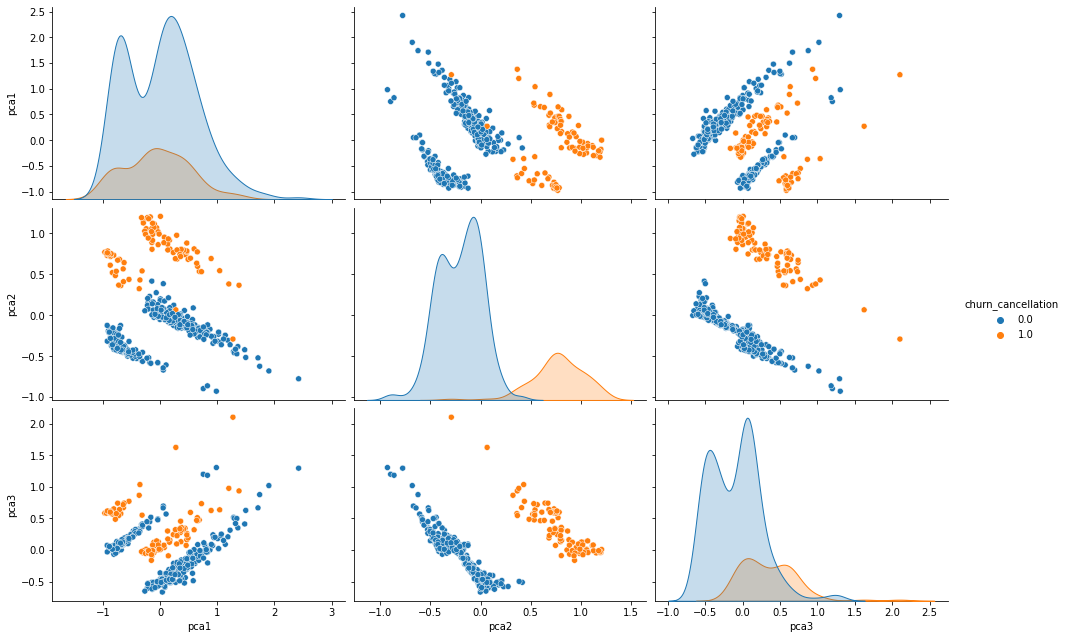

In [ ]:
fig = plt.figure(figsize=(15, 5))
df_graficar = pd.DataFrame()
df_graficar[['pca1', 'pca2','pca3']] = principalComponents[:,:3]
df_graficar['churn_cancellation'] = pre_pca['churn_cancellation']
sns.pairplot(data=df_graficar,  height=3, hue='churn_cancellation', aspect= 1.5) #,

<font color='mediumblue'>
A aprtir de la transformación realizada, se puede observar que favorece la separación de los grupos. Esto se observa con mayor intensidad en el caso del par pca2-pca3.<br>
A continuación, se selecciona un nuevo conjunto de variables relevantes:

In [ ]:
new_relevant= ['pca1', 'pca2', 'pca3']

#2. Creación de modelos de clustering: K-means 

Documentación: 
https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html 

##a. Buscamos el número de clusters óptimo observando la inercia de cada uno. 


In [ ]:
df_clustering = df_graficar[new_relevant]

Text(0.5, 1.0, 'Inertia of k-Means versus number of clusters')

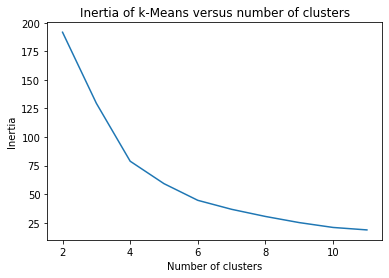

In [ ]:
scores = [KMeans(n_clusters=i).fit(df_clustering).inertia_ for i in range(2,12)]

plt.plot(np.arange(2, 12), scores)
plt.xlabel('Number of clusters')
plt.ylabel("Inertia")
plt.title("Inertia of k-Means versus number of clusters")

<font color='mediumblue'> 
La curva de inercia muestra un punto de inflexión a la altura de los 4 clusters.

##b. Correr K-means utilizando como parámetro el número de clusters obtenido en el punto anterior.

In [ ]:
km_4 = KMeans(n_clusters=4,n_init=25, random_state=123)
km_4.fit(df_clustering)
df_clustering['kmeans_4'] = km_4.labels_ # Agregamos las etiquetas al df
df_graficar['kmeans_4'] = km_4.labels_ # Agregamos las etiquetas al df
pre_pca['kmeans_4'] = km_4.labels_ # Agregamos las etiquetas al df

##c. Analizar la cantidad de casos en cada clúster. 

In [ ]:
df_clustering.kmeans_4.value_counts()

0    170
1    125
2     83
3     46
Name: kmeans_4, dtype: int64

##d. Grafique de a dos variables incluyendo el label obtenido en el clustering. ¿Es posible determinar alguna separación de grupos? 

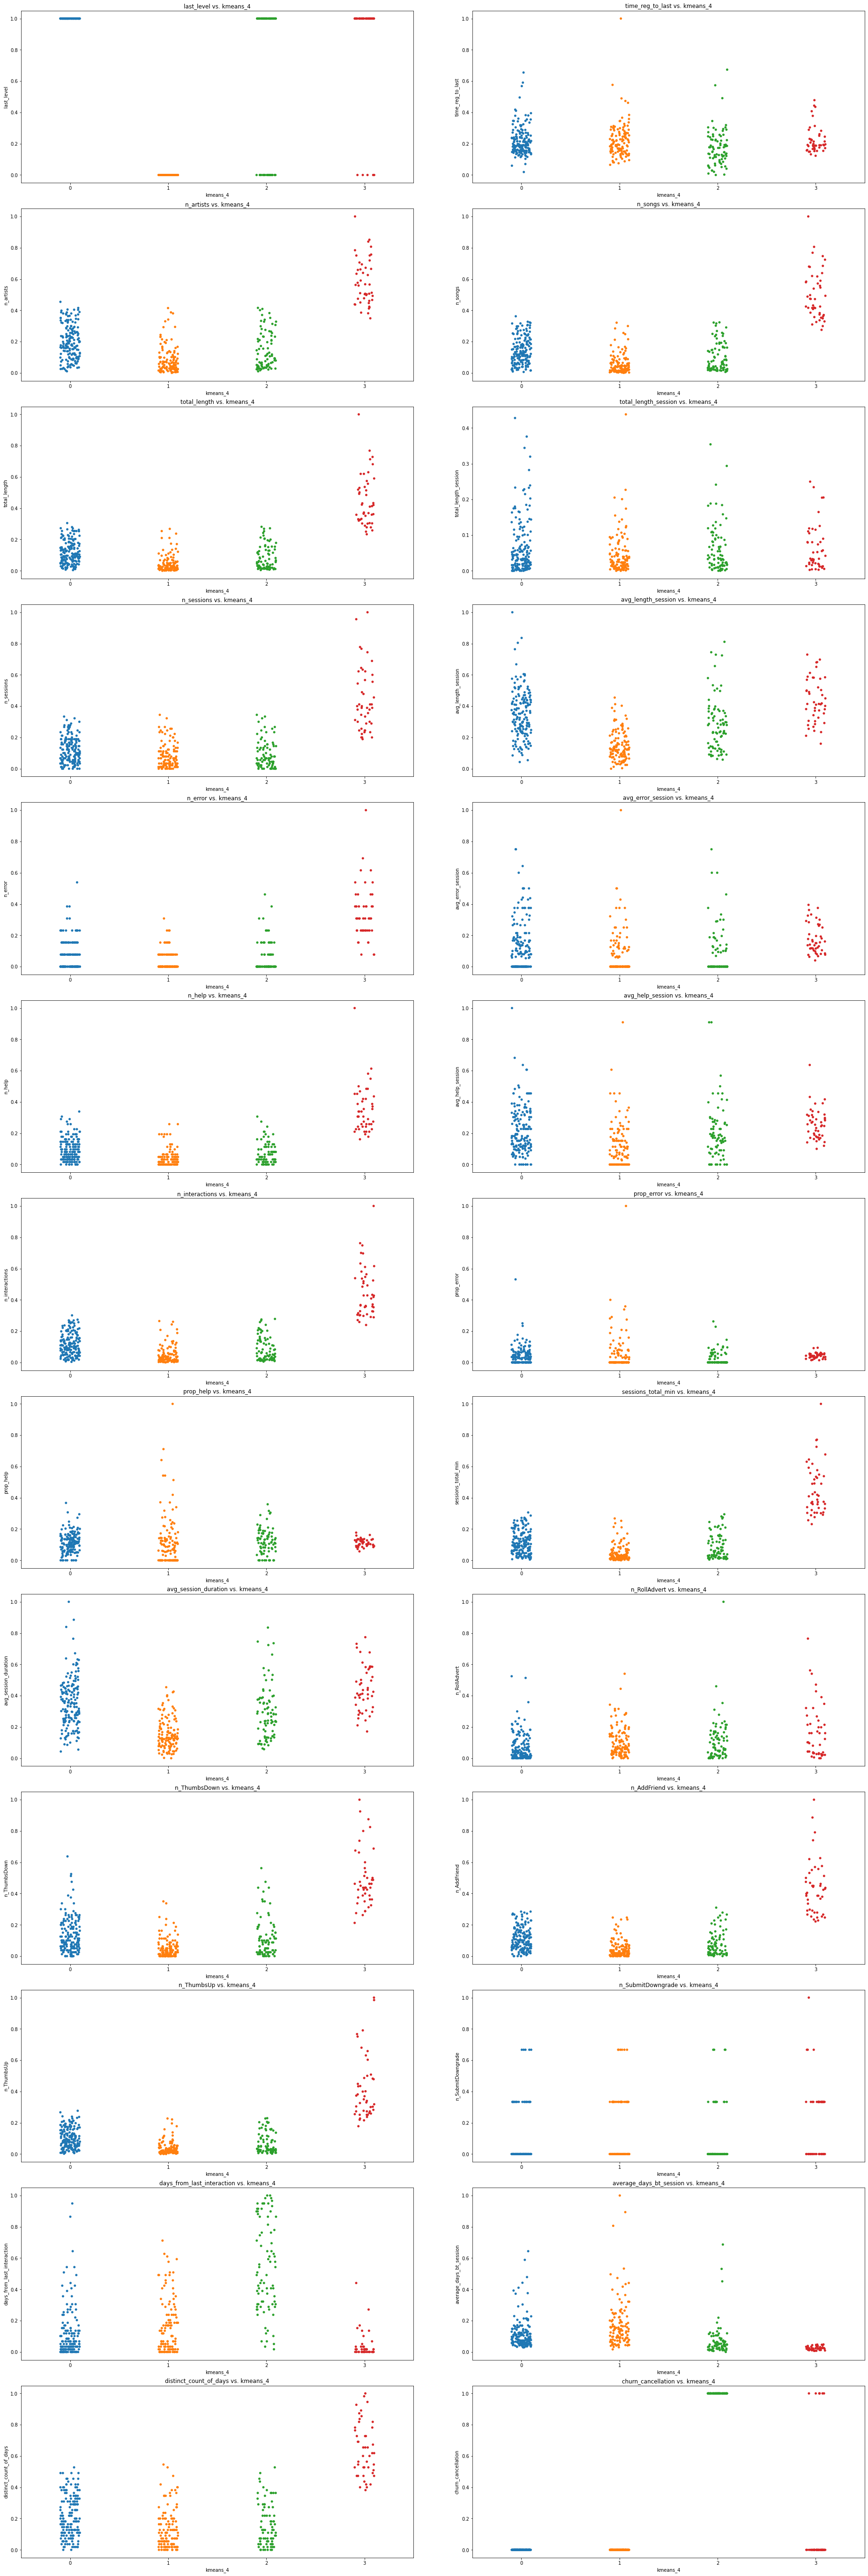

In [ ]:
unique = pre_pca['kmeans_4'].unique()
palette = dict(zip(unique, sns.color_palette(n_colors=len(unique))))

n_cols = 2
n_rows = int((len(relevant) + 1) // n_cols) + (len(relevant) % n_cols > 0)
x = 0
subplot = 0
fig = plt.figure(figsize=(50,100))
for i, col in enumerate(relevant):
    subplot = subplot + 1
    ax = fig.add_subplot(n_rows, n_cols, subplot)
    ax.set_title(relevant[i] + ' vs. kmeans_4')
    sns.stripplot(data=pre_pca, x='kmeans_4', y=relevant[i]) 
    fig.subplots_adjust(left=0, right=0.5, hspace=0.15, wspace=0.15)

<font color='mediumblue'> 
No se observan marcadas diferencias entre los clusters obtenidos. Se intentará aplicar el método nuevamente buscando 2 clusters.

In [ ]:
km_2 = KMeans(n_clusters=2,n_init=25, random_state=123)
km_2.fit(df_clustering)
df_clustering['kmeans_2'] = km_2.labels_ # Agregamos las etiquetas al df
df_graficar['kmeans_2'] = km_2.labels_ # Agregamos las etiquetas al df
pre_pca['kmeans_2'] = km_2.labels_ # Agregamos las etiquetas al df
df_clustering.kmeans_2.value_counts()

0    295
1    129
Name: kmeans_2, dtype: int64

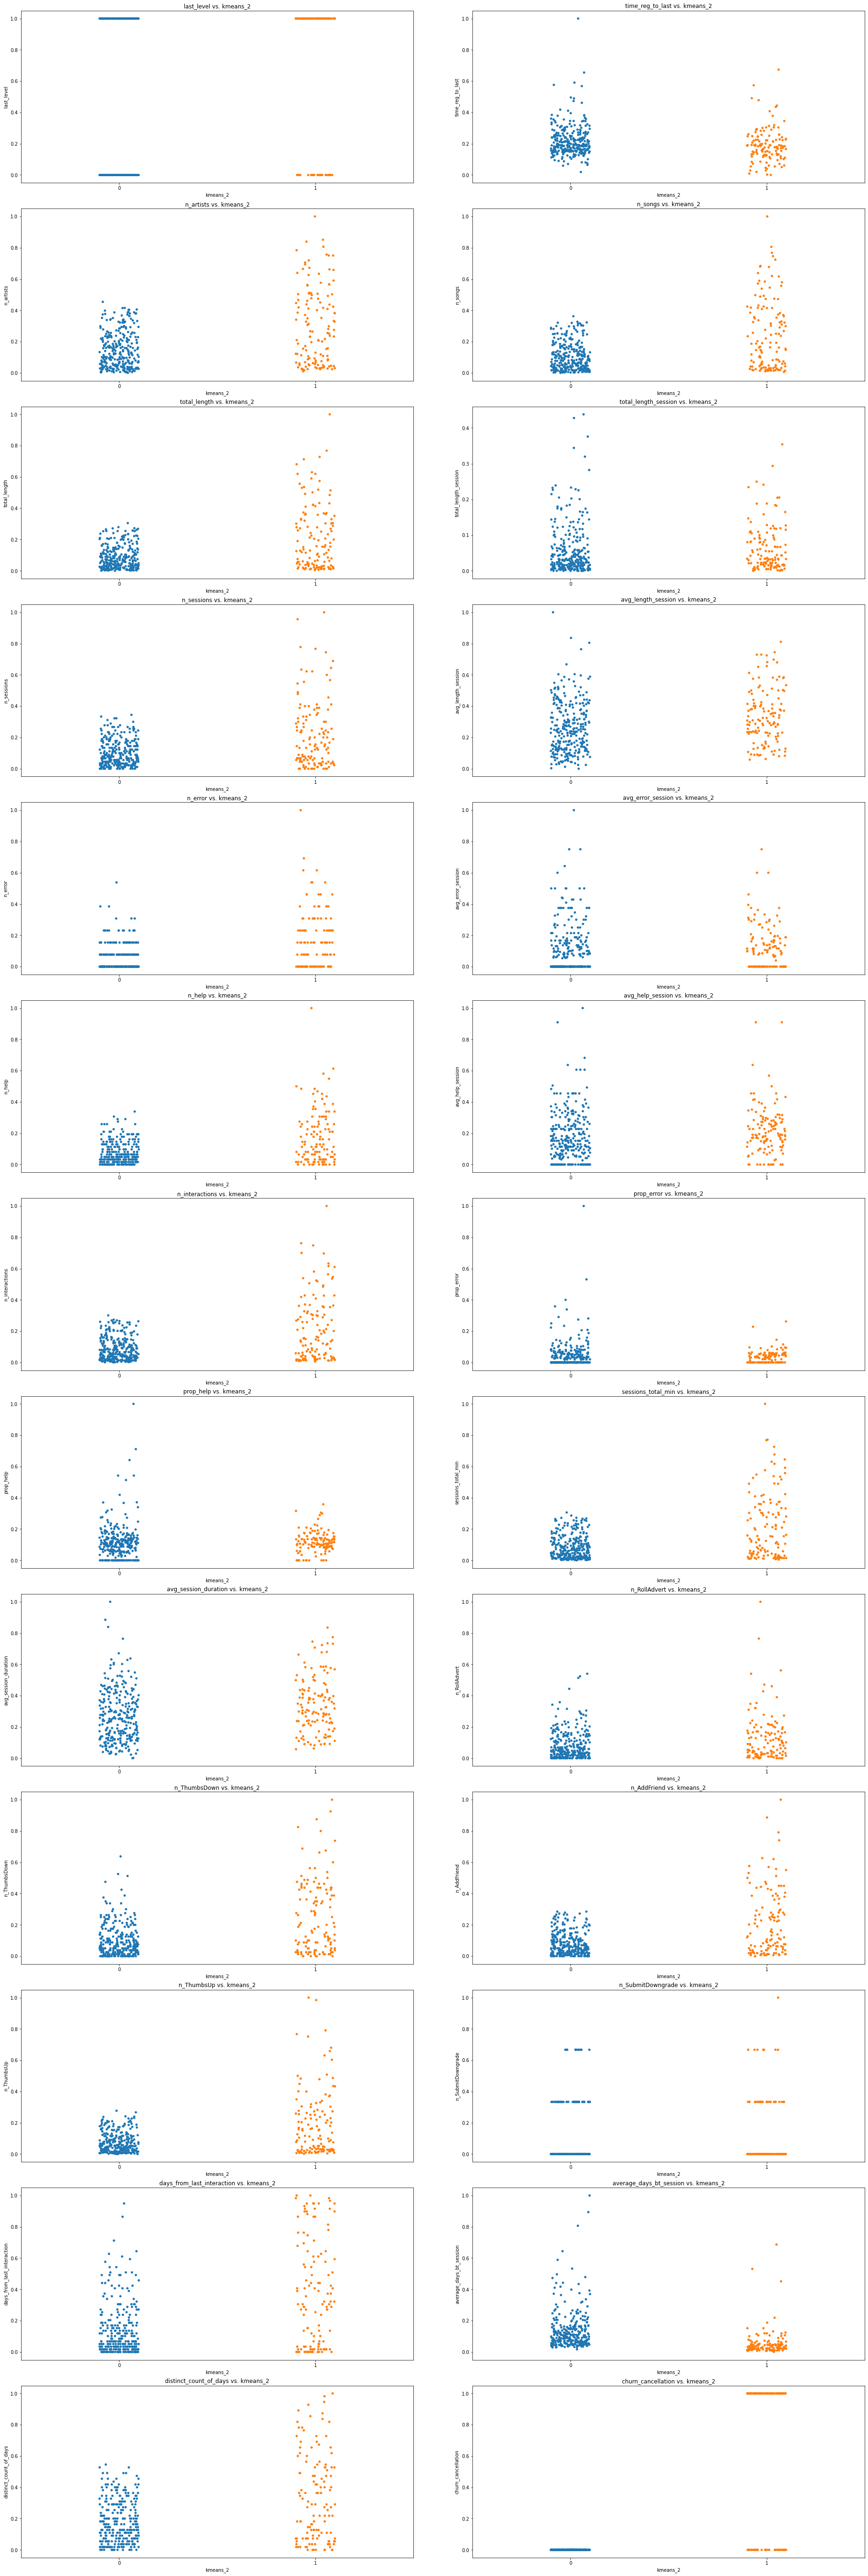

In [ ]:
unique = pre_pca['kmeans_2'].unique()
palette = dict(zip(unique, sns.color_palette(n_colors=len(unique))))

n_cols = 2
n_rows = int((len(relevant) + 1) // n_cols) + (len(relevant) % n_cols > 0)
x = 0
subplot = 0
fig = plt.figure(figsize=(50,100))
for i, col in enumerate(relevant):
    subplot = subplot + 1
    ax = fig.add_subplot(n_rows, n_cols, subplot)
    ax.set_title(relevant[i] + ' vs. kmeans_2')
    sns.stripplot(data=pre_pca, x='kmeans_2', y=relevant[i]) 
    fig.subplots_adjust(left=0, right=0.5, hspace=0.15, wspace=0.15)

<font color='mediumblue'> 
Para algunas variables, se observan grupos de usuarios que tendrían comportamientos diferentes en el uso de la aplicación. Por ejemplo, los usuarios del cluster 0 escuchan menor variedad de artistas y canciones e interactúan menos con la aplicación.

#3. Creación de modelos de clustering: Algoritmo Jerárquico 

Documentación: 
https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html 

##a. Realizar las aglomeraciones utilizando el algoritmo “AgglomerativeClustering”. 

In [ ]:
ac_4 = AgglomerativeClustering(n_clusters=4)
ac_4.fit(df_clustering)
df_clustering['ac_4'] = ac_4.labels_ # Agregamos las etiquetas al df
df_graficar['ac_4'] = ac_4.labels_ # Agregamos las etiquetas al df
pre_pca['ac_4'] = ac_4.labels_ # Agregamos las etiquetas al df

##b. Analizar la cantidad de casos en cada clúster. 

In [ ]:
df_clustering.ac_4.value_counts()

1    170
2    125
0     83
3     46
Name: ac_4, dtype: int64

##c. Grafique de a dos variables incluyendo el label obtenido en el clustering. ¿Es posible determinar alguna separación de grupos? 


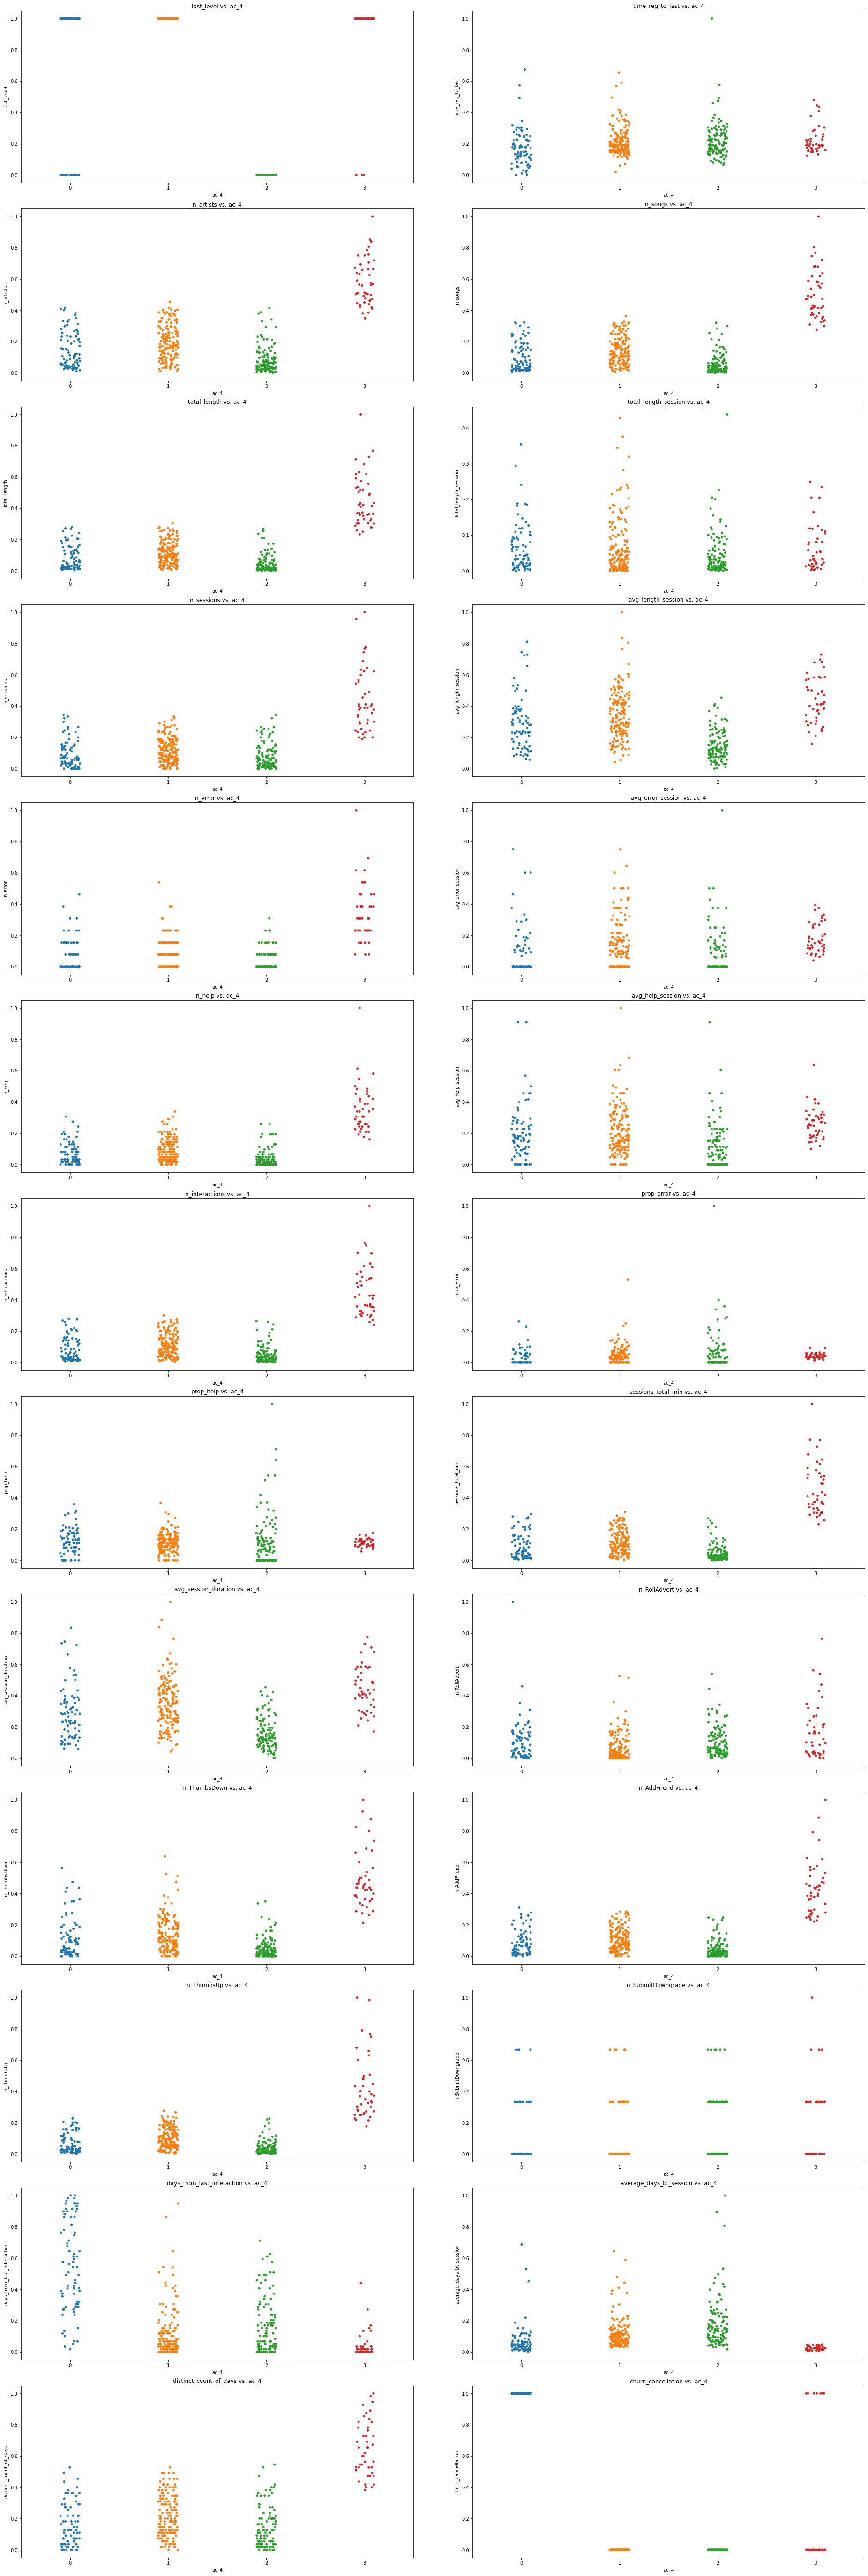

In [ ]:
unique = pre_pca['ac_4'].unique()
palette = dict(zip(unique, sns.color_palette(n_colors=len(unique))))

n_cols = 2
n_rows = int((len(relevant) + 1) // n_cols) + (len(relevant) % n_cols > 0)
x = 0
subplot = 0
fig = plt.figure(figsize=(50,100))
for i, col in enumerate(relevant):
    subplot = subplot + 1
    ax = fig.add_subplot(n_rows, n_cols, subplot)
    ax.set_title(relevant[i] + ' vs. ac_4')
    sns.stripplot(data=pre_pca, x='ac_4', y=relevant[i]) 
    fig.subplots_adjust(left=0, right=0.5, hspace=0.15, wspace=0.15)

<font color='mediumblue'> 
En este caso, los grupos de puntos parecen mostrar diferencias entre sí con respecto a las variables que se graficaron. Por ejemplo, el cluster 0 incluye a todos los usuarios que hicieron churn, mientras que los clusters 1, 2 y 3 incluyen al resto de usuarios. Además, el cluster 1 es el que más interactúa con la aplicación. Los clusters 3 y 4 dejan pasar más tiempo entre sesión y sesión. 

##d. Como conclusión ¿cuál algoritmo de clustering parece haber funcionado mejor para el set de datos trabajado? 

<font color='mediumblue'> 
Como se mencionó en el punto anterior, el método aglomerativo lleva a cabo una mejor segmentación de los usuarios, ya que los gráficos mostraron resultados con mayor nivel de interpretabilidad sobre las características de cada grupo.